In [1]:
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from utils import calcOneChi2, HistMaker_1d, diffHist, setOPT_text, setTH1, setPad, geomAvg1d, ratioErr, symmetrize
from ROOT import TFile, TH1, TH3F, TF2, TF1, TCanvas, TStyle, gStyle, Form, Fit, TLegend
import scipy.optimize as opt
import math
import calendar, os
from time import time, gmtime

Welcome to JupyROOT 6.28/04


In [2]:
gStyle.SetOptStat(0)

same_sign_symm = False
ag1580ag = True
event_mixing = False
read_saved = True
range_used = range(0,12)

if read_saved:
    if event_mixing:
        if ag1580ag:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d_ag1580ag"
        else:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d"
    else:
        if ag1580ag:
            DIR_NAME = "results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr"
        else:
            DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
ag1580ag = True

if ag1580ag:
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho = "mar19_diele_inmedium_heli0cm_ag1580ag_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
        filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
        filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
else:
    filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "088_090_ag123ag_2500A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho = "mar19_diele_inmedium_heli0cm_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"


frame = Frame.CS

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMaker_1d("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMaker_1d(filename_data_np_mix, "_data_np", bins, frame)
else:
    histMakerData_np = HistMaker_1d(filename_data_np, "_data_np", bins, frame)
histsData_np = histMakerData_np.makeHists()
histMakerData_pp = HistMaker_1d(filename_data_pp, "_data_pp", bins, frame)
histsData_pp = histMakerData_pp.makeHists()
histMakerData_nn = HistMaker_1d(filename_data_nn, "_data_nn", bins, frame)
histsData_nn = histMakerData_nn.makeHists()

histMakerData_np_mix = HistMaker_1d(filename_data_np_mix, "_data_pp_mix", bins, frame)
histsData_np_mix = histMakerData_np_mix.makeHists()
histMakerData_pp_mix = HistMaker_1d(filename_data_np_mix, "_data_pp_mix", bins, frame)
histsData_pp_mix = histMakerData_pp_mix.makeHists()
histMakerData_nn_mix = HistMaker_1d(filename_data_nn_mix, "_data_nn_mix", bins, frame)
histsData_nn_mix = histMakerData_nn_mix.makeHists()

histMakerMC_rho = HistMaker_1d(filename_MC_rho, "_MC_rho", bins, frame)
histMakerMC_pi0 = HistMaker_1d(filename_MC_pi0, "_MC_pi0", bins, frame)
histMakerMC_mix = HistMaker_1d(filename_MC_mix, "_MC_mix", bins, frame)
#histMakerMC_mix = HistMaker_1d("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMaker_1d("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def getHistMakerMC(HIST_INDEX):
    if event_mixing:
        return histMakerMC_mix
    else:
        return histMakerMC_pi0 if HIST_INDEX < 3 else histMakerMC_rho

iter 0
#1 [[<cppyy.gbl.TH1F object at 0x16c18d9f0>, <cppyy.gbl.TH1F object at 0x16c190480>, <cppyy.gbl.TH1F object at 0x16c190870>, <cppyy.gbl.TH1F object at 0x16c190c60>, <cppyy.gbl.TH1F object at 0x16c191050>, <cppyy.gbl.TH1F object at 0x16c191440>, <cppyy.gbl.TH1F object at 0x16c191830>, <cppyy.gbl.TH1F object at 0x16c191c20>, <cppyy.gbl.TH1F object at 0x16c192010>, <cppyy.gbl.TH1F object at 0x16c192400>, <cppyy.gbl.TH1F object at 0x16c1927f0>, <cppyy.gbl.TH1F object at 0x16c192be0>], [<cppyy.gbl.TH1F object at 0x16c192fd0>, <cppyy.gbl.TH1F object at 0x16c193950>], [<cppyy.gbl.TH1F object at 0x16c1933c0>, <cppyy.gbl.TH1F object at 0x16c193ee0>]]
#2 [[<cppyy.gbl.TH1F object at 0x16c395960>, <cppyy.gbl.TH1F object at 0x16c396080>, <cppyy.gbl.TH1F object at 0x16c396470>, <cppyy.gbl.TH1F object at 0x16c396860>, <cppyy.gbl.TH1F object at 0x16c396c50>, <cppyy.gbl.TH1F object at 0x16c397040>, <cppyy.gbl.TH1F object at 0x16c397430>, <cppyy.gbl.TH1F object at 0x16c397820>, <cppyy.gbl.TH1F ob

Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_0to150_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_150to300_p03p08_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_m06p00_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p00p03_data_pp_mix_iter4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_300to450_p03p08_data_

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/histsData_np.gif has been created


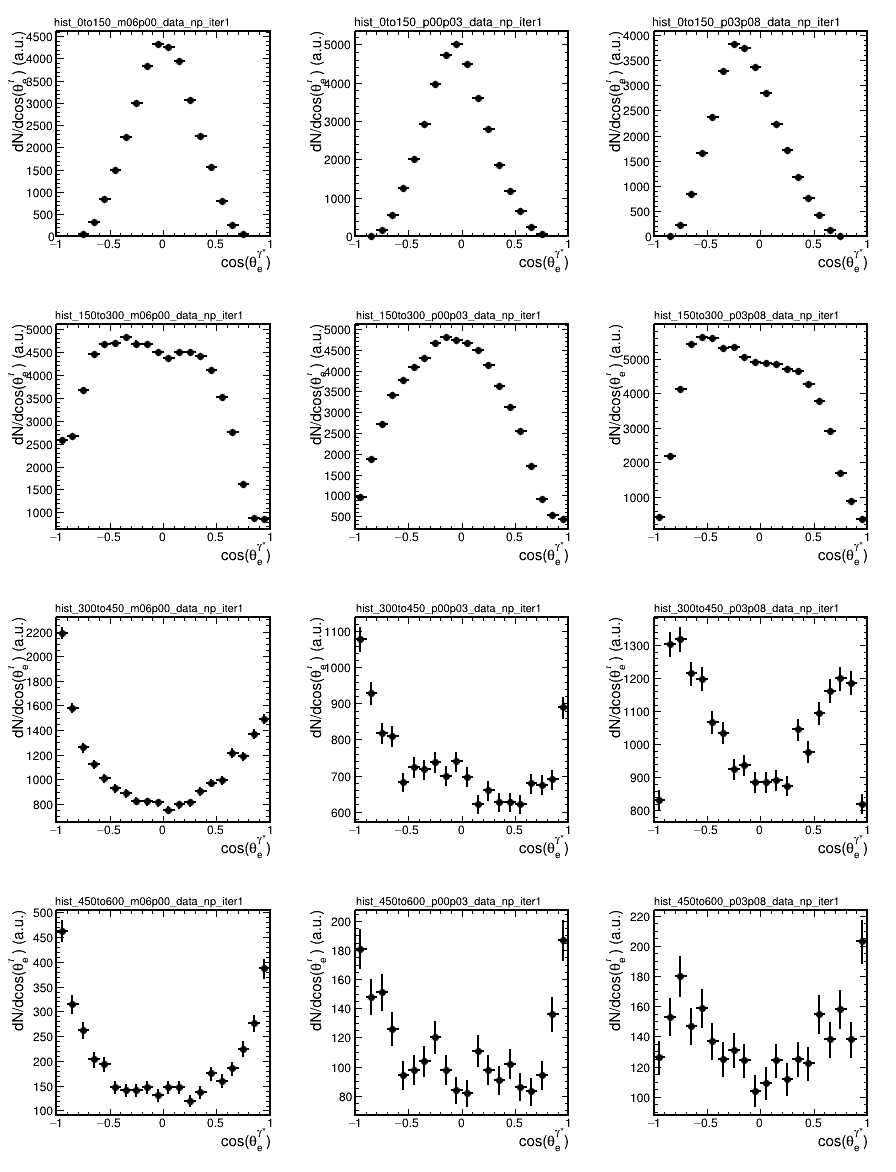

In [4]:
can4 = TCanvas("can4","can4",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData_np[0]):
    pad = can4.cd(i+1)
    setPad(pad)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        setTH1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.Draw()
    else:
        print(hist)

can4.SaveAs(f'{DIR_NAME}/histsData_np.gif')

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/base_hists_pi0_MC.gif has been created


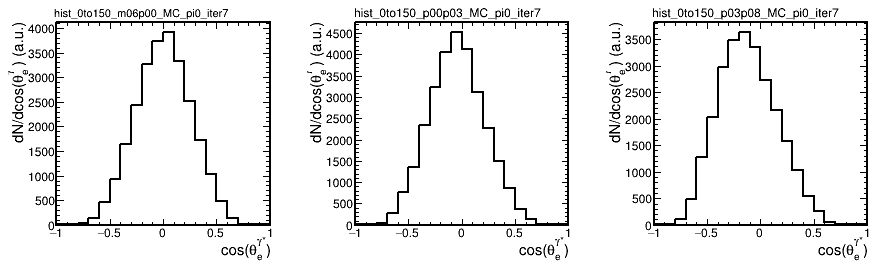

In [5]:
base_hists_pi0 = histMakerMC_pi0.builder.base_hists
can3 = TCanvas("can3","can3",900,300)
can3.Divide(3,1)
can3.Draw()
for i, hist in enumerate(base_hists_pi0[0]):
    if i < 3:
        pad = can3.cd(i+1)
        setPad(pad)

        if not isinstance(hist, list):
            hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
            setTH1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
            hist.Draw()
        else:
            print(hist)
can3.SaveAs(f"{DIR_NAME}/base_hists_pi0_MC.gif")

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/base_hists_rho_MC.gif has been created


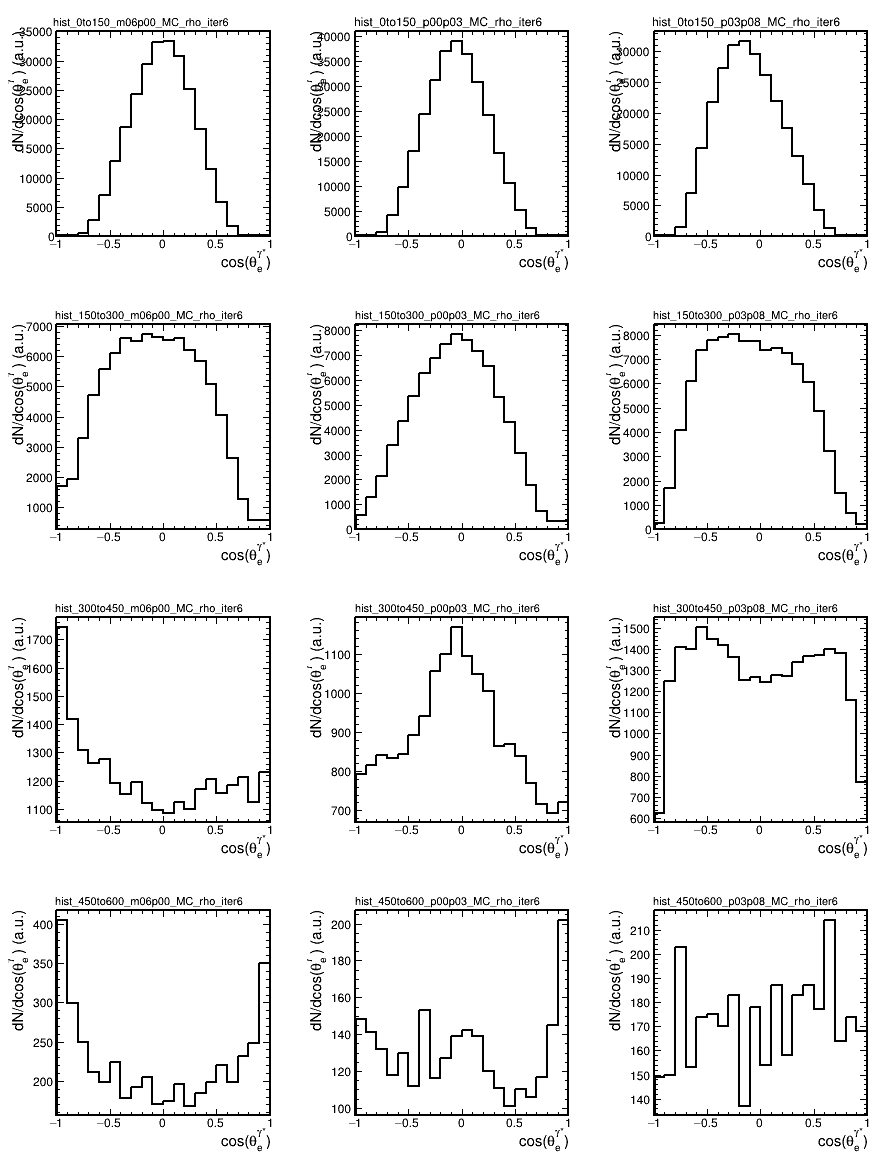

In [6]:
base_hists_rho = histMakerMC_rho.builder.base_hists
can5 = TCanvas("can5","can5",900,1200)
can5.Divide(3,4)
can5.Draw()
for i, hist in enumerate(base_hists_rho[0]):
    pad = can5.cd(i+1)
    setPad(pad)
    if not isinstance(hist, list):
        hist.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        setTH1(hist, hist.GetXaxis().GetTitle(), f"dN/d{hist.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.Draw()
    else:
        print(hist)
can5.SaveAs(f'{DIR_NAME}/base_hists_rho_MC.gif')


In [7]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [8]:
TH1.SetDefaultSumw2

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [9]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [10]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
# class GPModel(gpytorch.models.ApproximateGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        mean_x = mean_x.to(mps_device)
        covar_x = covar_x.to(mps_device)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def fit_gp_model(train_x, train_y, num_train_iters=500):
    train_x = train_x.to(mps_device)
    train_y = train_y.to(mps_device)

    # declare the GP
    noise = 1e-1

    likelihood = gpytorch.likelihoods.StudentTLikelihood()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise
    likelihood = likelihood.to(mps_device)
    model = model.to(mps_device)

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model.cpu(), likelihood.cpu()

In [11]:
# TODO: Come back to standard version
#num_queries = 75
num_queries = 200
num_repeats = 1
num_samples = 20

In [12]:
# -2 is the default value when no feasible has been found
default_value = -1

def fit_bo(HIST_INDEX = 0):
    global bounds

    def objective(xx):
        def generator(xx):
            for x in xx:
                lambda_theta = x

                histsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
                chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX])
                allHistsMC.append(histsMC[0][HIST_INDEX])
                if not chi2 or not ndf:
                    return torch.tensor([0])
                yield torch.tensor([1.0/(chi2 / ndf)])
        return torch.stack([a for a in generator(xx)])

    def one_starting_sample():
        result = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(N_PARAMS)
        return result

    feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

    best_fs = []

    print(f"HIST INDEX: {HIST_INDEX}")
    for trial in range(num_repeats):
       # print("trial", trial)

        torch.manual_seed(trial)
       # train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
       # while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
       #     train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
        train_x = torch.stack([one_starting_sample() for _ in range(num_samples)])
        train_utility = objective(train_x).to(mps_device)
        train_x = train_x.to(mps_device)

        for i in tqdm(range(num_queries)):
            feasible_incumbents[trial, i] = train_utility.max()
            before_fit_gp = time()
            utility_model, utility_likelihood = fit_gp_model(
                train_x, train_utility.squeeze(-1)
            )
            after_fit_gp = time()
           # print("Fitting GP took " + str(after_fit_gp - before_fit_gp) + " seconds")
            best_f = train_utility.max()
            best_fs.append(best_f.item())
                
           # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
           # policy = botorch.acquisition.analytic.LogExpectedImprovement(
            policy = botorch.acquisition.logei.qLogExpectedImprovement(
          # policy = botorch.acquisition.analytic.LogProbabilityOfImprovement(
          # policy = botorch.acquisition.analytic.PosteriorMean(
                model=utility_model,
                best_f=train_utility.max(),
            ).to(mps_device)

            before_optimize_acqf = time()
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=RuntimeWarning)
                next_x, acq_val = botorch.optim.optimize_acqf(
                    policy,
                    bounds=bounds,
                    #q=5,
                    #num_restarts=5,
                    #raw_samples=400,
                    q=1,
                    num_restarts=40,
                    raw_samples=100,
                )
            after_optimize_acqf = time()
           # print("Optimizing ACQF took " + str(after_optimize_acqf - before_optimize_acqf) + " seconds")

            next_utility = objective(next_x).to(mps_device)

            train_x = torch.cat([train_x, next_x])
            train_utility = torch.cat([train_utility, next_utility])
    torch.save(feasible_incumbents, f"{DIR_NAME}/incumbents_" + str(HIST_INDEX) + ".pth")
    fout = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root","RECREATE")
    fout.cd()
    for hist in allHistsMC:
       # print ("Writing hist: ", hist.GetName())
        hist.Write()
    for j, hists in enumerate(histsData_np):
        for k, hist in enumerate(hists):
                hist.Write()
               # print ("Writing hist: ", j, k, hist)
    fout.Close()

    with torch.no_grad():
        predictive_distribution = utility_likelihood(utility_model(xs))
        acquisition_score = policy(xs.unsqueeze(1))

    lambda_thetas     = train_x.flatten()
    
    c = torch.stack((
        torch.arange(0,num_queries, dtype=int),
        lambda_thetas[0:num_queries],
        train_utility.squeeze()[0:num_queries],
        (feasible_incumbents==feasible_incumbents.max())[0],
        feasible_incumbents[0]
    ),0).transpose(-2,-1)
    torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
    sort_index = c[:, N_PARAMS + 1].sort()[1]
    c_sorted = c[sort_index]
    train_x_sorted = train_x[sort_index]

    return c_sorted, train_x_sorted, predictive_distribution

In [13]:
c_sorted_all = []
train_x_sorted_all = []
predictive_mean_all = []
predictive_lower_all = []
predictive_upper_all = []

for HIST_INDEX in range_used:
    allHistsMC = []
    if read_saved:
        c_sorted = torch.load(f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        train_x_sorted = torch.load(f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        predictive_distribution = torch.load(f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

        file = TFile(f"{DIR_NAME}/out_{HIST_INDEX}.root", "read")
        names = [key.GetName() for key in file.GetListOfKeys()]
        names = [name for name in names if "MC" in name]
        for name in names:
            allHistsMC.append(file.Get(name))
    else:
        c_sorted, train_x_sorted, predictive_distribution = fit_bo(HIST_INDEX)
        print(c_sorted[-5:])
        
        torch.save(c_sorted, f"{DIR_NAME}/c_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(train_x_sorted, f"{DIR_NAME}/train_x_sorted_" + str(HIST_INDEX) + ".pth")
        torch.save(predictive_distribution, f"{DIR_NAME}/predictive_distribution_" + str(HIST_INDEX) + ".pth")

    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()
    print("AFTER_READING: ", predictive_mean[100], predictive_lower[100], predictive_upper[100])

    c_sorted_all.append(c_sorted)
    train_x_sorted_all.append(train_x_sorted)
    predictive_mean_all.append(predictive_mean)
    predictive_lower_all.append(predictive_lower)
    predictive_upper_all.append(predictive_upper)



AFTER_READING:  tensor(0.3662) tensor(0.3083) tensor(0.4240)
AFTER_READING:  tensor(0.2084) tensor(0.1474) tensor(0.2694)
AFTER_READING:  tensor(0.1166) tensor(0.0434) tensor(0.1898)
AFTER_READING:  tensor(0.0455) tensor(-0.0220) tensor(0.1130)
AFTER_READING:  tensor(0.0895) tensor(0.0300) tensor(0.1491)
AFTER_READING:  tensor(0.0318) tensor(-0.0349) tensor(0.0986)
AFTER_READING:  tensor(0.0524) tensor(-0.2020) tensor(0.3067)
AFTER_READING:  tensor(0.0526) tensor(-0.1688) tensor(0.2741)
AFTER_READING:  tensor(0.0290) tensor(-0.0514) tensor(0.1095)
AFTER_READING:  tensor(0.1459) tensor(-0.1816) tensor(0.4734)
AFTER_READING:  tensor(0.1164) tensor(-0.0489) tensor(0.2818)
AFTER_READING:  tensor(0.1094) tensor(-0.0615) tensor(0.2804)


In [14]:
from ipywidgets import interact, Layout, IntSlider, FloatSlider
import numpy as np

axis_title = r"$cos(\theta_e^{\gamma*})$"

def oneplot(ax, tensor, title):
        
        global xs
        
       # pos = ax.plot(xs, tensor, ymin=0, ymax=tensor.max())
        pos = ax.plot(xs, tensor)
       # ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(axis_title)

can_cmp_ind = 0

def plotComparison(can, pad_nr1, pad_nr2, histMC, histData, hist_index, pull_title):
   # print(f"PLOTTING: {histMC.GetName()} and {histData.GetName()}")
    global can_cmp_ind

    curr_bin = bins[hist_index]
    title = f"{curr_bin.m_min} < #it{{M}}_{{ee}} < {curr_bin.m_max}, {curr_bin.z_min} < cos(#theta^{{CM}}_{{#gamma*}}) < {curr_bin.z_max}"
    
    pad = can.cd(pad_nr1)
    setPad(pad)
    pad.SetRightMargin(0.16)
    histData.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
    histData.SetTitle(title)
    setTH1(histData, histData.GetXaxis().GetTitle(), f"dN/d{histData.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
    histData.Draw()
    histMC.Scale(histData.Integral()/histMC.Integral())
    histMC.SetLineColor(2)
    histMC.Draw("SAMEHIST")
    pad = can.cd(pad_nr2)
    setPad(pad)
    pad.SetRightMargin(0.16)
    hdiff = diffHist(histMC, histData)
    hdiff.SetTitle(pull_title)
    setTH1(hdiff, hdiff.GetXaxis().GetTitle(), "Pull value", 505, 20, 0.8, 2)
    hdiff.Draw("HIST")
    can.Update()
    can.Modified()
    can.Update()
    
    return hdiff

def xAxisProperties(histMC, histData):
    n = 0
    meanX2 = 0
    for i, (c1, c2) in enumerate(zip(histMC, histData)):
        if c1 != 0 and c2 != 0:
            n = n + 1
            meanX2 = meanX2 + math.pow(histMC.GetBinCenter(i+1), 2)
    if n > 0:
        meanX2 = meanX2 / n
    varX2 = 0
    sigma2 = 0
    for i, (c1, c2) in enumerate(zip(histMC, histData)):
        if c1 != 0 and c2 != 0:
            center = histData.GetXaxis().GetBinCenter(i+1)
            varX2 = varX2 + math.pow(math.pow(center, 2) - meanX2, 2)
            sigma2 = sigma2 + math.pow((c2 - c1)/c1 , 2)
    if n > 2:
        sigma2 = sigma2/(n-2)
    return n, meanX2, varX2, sigma2

In [15]:
def bin_index(x, min, max):
        return int((x-min)/(max-min)*101)

def covariance_fit_scipy(predictive_mean, predictive_lower, predictive_upper, best, HIST_INDEX, ax):
    def gaus1d(x, A, mean_x, sigma_x):
        x = x - mean_x
        z = A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z
    def gaus1d_offset(x, A, mean_x, sigma_x, offset):
        x = x - mean_x
        z = offset + A * np.exp( -0.5 * (x/sigma_x) ** 2 )
        return z

    def fit_1d(ax):
        curr_bin = bins[HIST_INDEX]
        title = f"{curr_bin.m_min} < $M_{{ee}}$ < {curr_bin.m_max}, {curr_bin.z_min} < $cos(\\theta^{{CM}}_{{\gamma*}})$ < {curr_bin.z_max}"
        
        mean_x = best[0].item()

        scale1 = bounds[1][0].item()
        scale2 = bounds[1][0].item()
        proj_min_X = bounds[0][0].item()
        proj_max_X = bounds[1][0].item()

        proj = predictive_mean
        proj_lower = predictive_lower
        proj_upper = predictive_upper

       # xmin_ind = max(0,   bin_index(mean_x, proj_min_X, proj_max_X)-50)
       # xmax_ind = min(100, bin_index(mean_x, proj_min_X, proj_max_X)+50)
        xmin_ind = 0
        xmax_ind = 100
        xmin = proj_min_X + xmin_ind / 101. * (proj_max_X - proj_min_X)
        xmax = proj_min_X + (xmax_ind + 1) / 101. * (proj_max_X - proj_min_X)

        x = np.linspace(-2, 2, 101)

        proj1 = proj[xmin_ind:xmax_ind]
        print("range ", xmin_ind, xmax_ind, xmin, xmax)
    
       # initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X))
        initial_guess = (1.0, mean_x, 0.2*(proj_max_X-proj_min_X), 0)
        eps = 0.001
       # param_bounds = ([0,mean_x-eps,0],[np.inf,mean_x+eps,2])
       # if mean_x >= 1.0:
       #     param_bounds = ([0,mean_x-eps,0],[np.inf,2,2])
        param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,mean_x+eps,2,np.inf])
        if mean_x >= 1.0:
            param_bounds = ([0,mean_x-eps,0,-np.inf],[np.inf,2,2,np.inf])
       # ax.plot(x, proj, label="Estimated values")
        ax.plot(x, proj)
        ax.fill_between(x, proj_lower, proj_upper, alpha=0.5)
        ax.plot(x, proj, label="Estimated values")
        ax.set_title(title)
        ax.set_xlabel(r"$\lambda_{\theta}$")
        ax.set_ylabel("ndf$/\chi^2$")
        ax.set_ylim(0,1.5*proj_upper.max())
        try:
            popt, pcov = opt.curve_fit(gaus1d_offset, x[xmin_ind:xmax_ind], proj1, p0 = initial_guess, bounds=param_bounds, maxfev=2000)
            fit_result = gaus1d_offset(x, *(popt))
    
            ax.plot(x, fit_result, label="Gaussian fit")
           # ax.set_ylim([0,2*predictive_upper.max()])
           # plt.rc('axes', titlesize=8)
           # plt.rc('axes', labelsize=8) 
           # plt.rc('xtick', labelsize=8)
           # plt.rc('ytick', labelsize=8)
            ax.legend()
        except RuntimeError as e:
            print(f"There was an exception {e}")
            popt, pcov = None, None
        return popt, pcov

   # params0, _ = fit_1d(ax[1][0])
    params0, _ = fit_1d(ax)
    plt.savefig(f"{DIR_NAME}/chi2_best_{HIST_INDEX}.png", bbox_inches="tight")

    try:
        return params0[1], params0[2]
    except:
        return None

#2 [[<cppyy.gbl.TH1F object at 0x44def1910>, <cppyy.gbl.TH1F object at 0x45882ce60>, <cppyy.gbl.TH1F object at 0x45882d250>, <cppyy.gbl.TH1F object at 0x458838ee0>, <cppyy.gbl.TH1F object at 0x4588371a0>, <cppyy.gbl.TH1F object at 0x458837590>, <cppyy.gbl.TH1F object at 0x458837980>, <cppyy.gbl.TH1F object at 0x458837d70>, <cppyy.gbl.TH1F object at 0x458838160>, <cppyy.gbl.TH1F object at 0x458838550>, <cppyy.gbl.TH1F object at 0x4588587c0>, <cppyy.gbl.TH1F object at 0x458858bb0>], [<cppyy.gbl.TH1F object at 0x2b170b870>, <cppyy.gbl.TH1F object at 0x2b170c050>], [<cppyy.gbl.TH1F object at 0x2b170bc60>, <cppyy.gbl.TH1F object at 0x2b170c440>]]
#2 [[<cppyy.gbl.TH1F object at 0x4589091d0>, <cppyy.gbl.TH1F object at 0x4589095c0>, <cppyy.gbl.TH1F object at 0x4589099b0>, <cppyy.gbl.TH1F object at 0x458909da0>, <cppyy.gbl.TH1F object at 0x45890a190>, <cppyy.gbl.TH1F object at 0x45890a580>, <cppyy.gbl.TH1F object at 0x453ef6bf0>, <cppyy.gbl.TH1F object at 0x453ef6fe0>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_0.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_1.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_2.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_3.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_4.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_5.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_6.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/comparison_7.gif has been created
Info in <TCanvas::Print>: gif fi

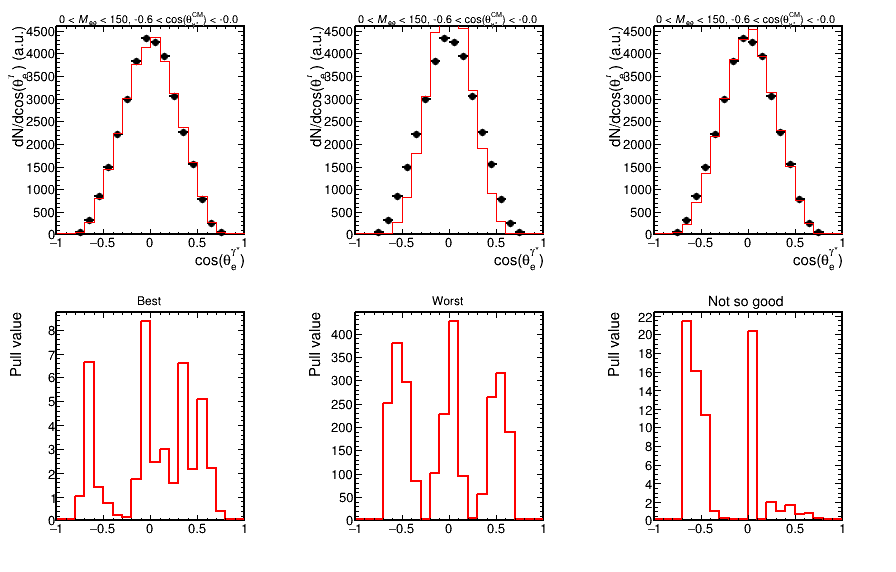

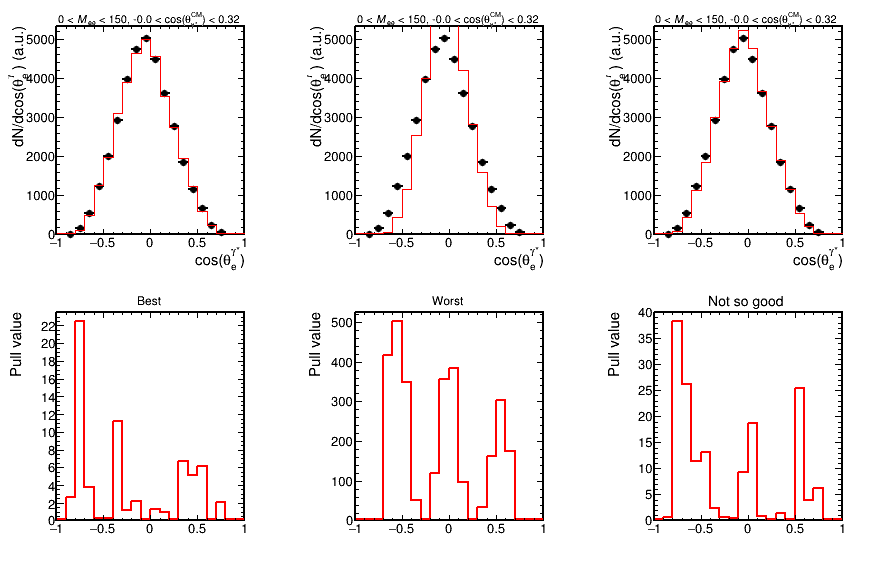

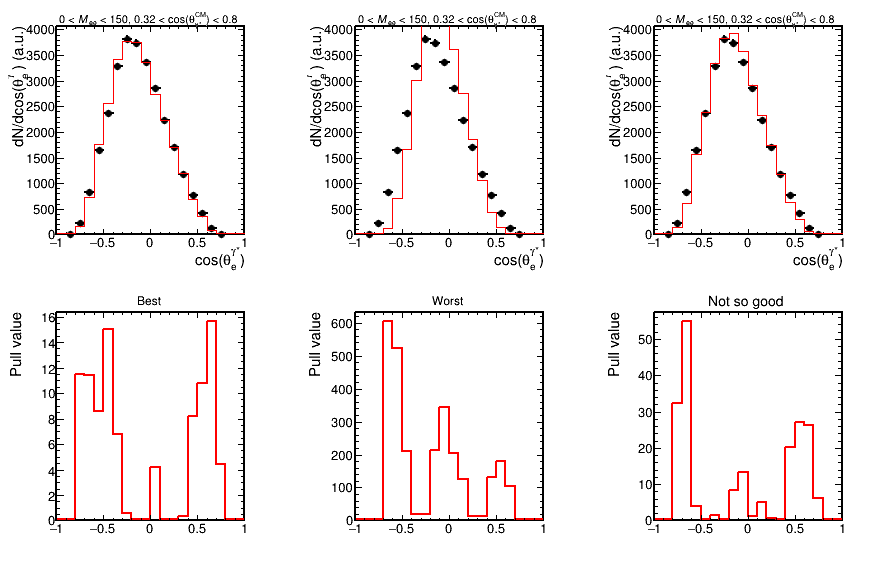

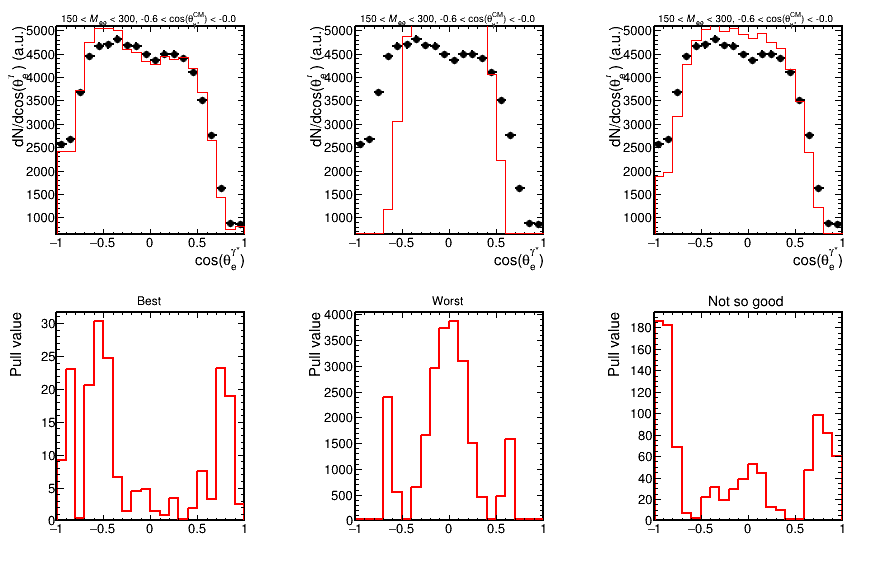

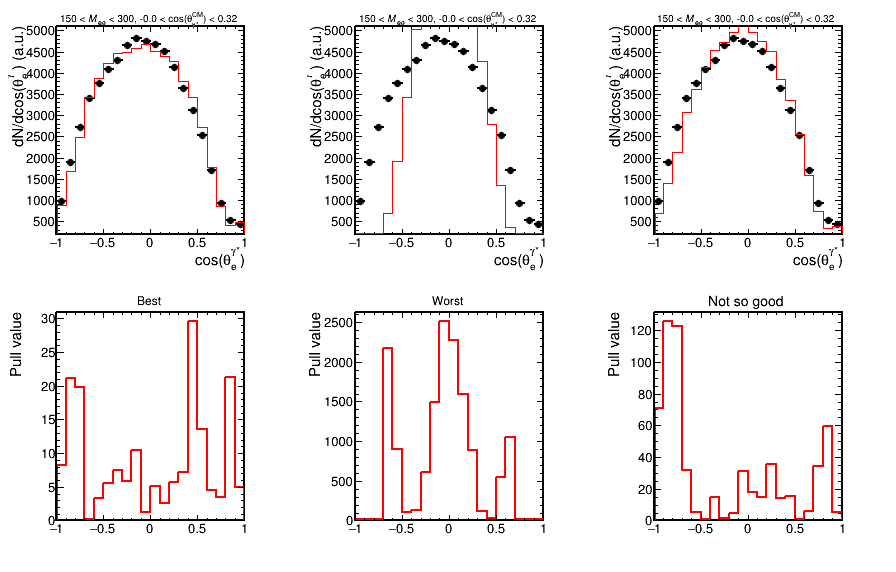

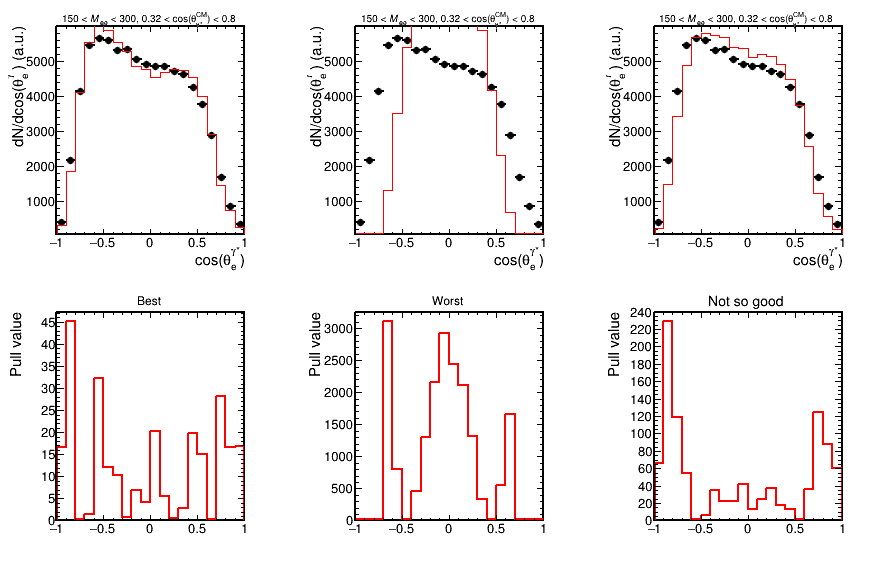

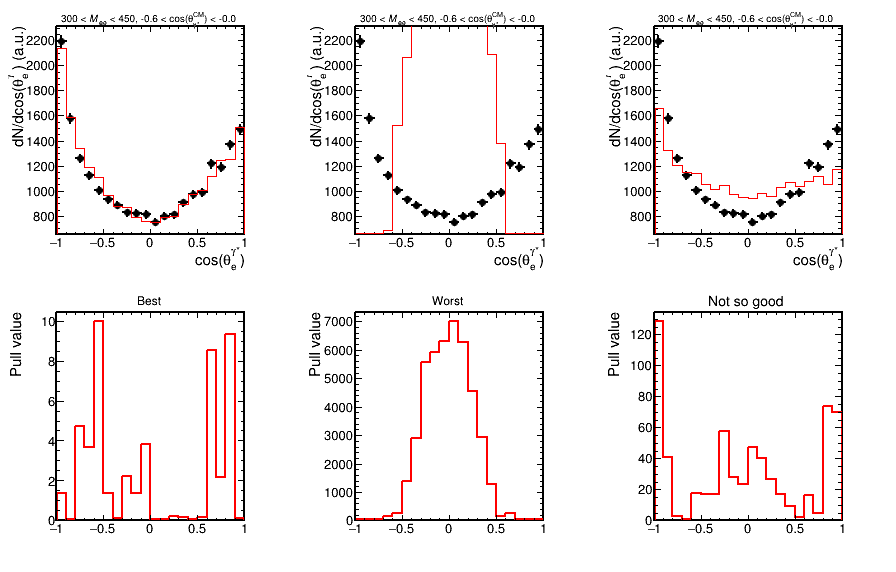

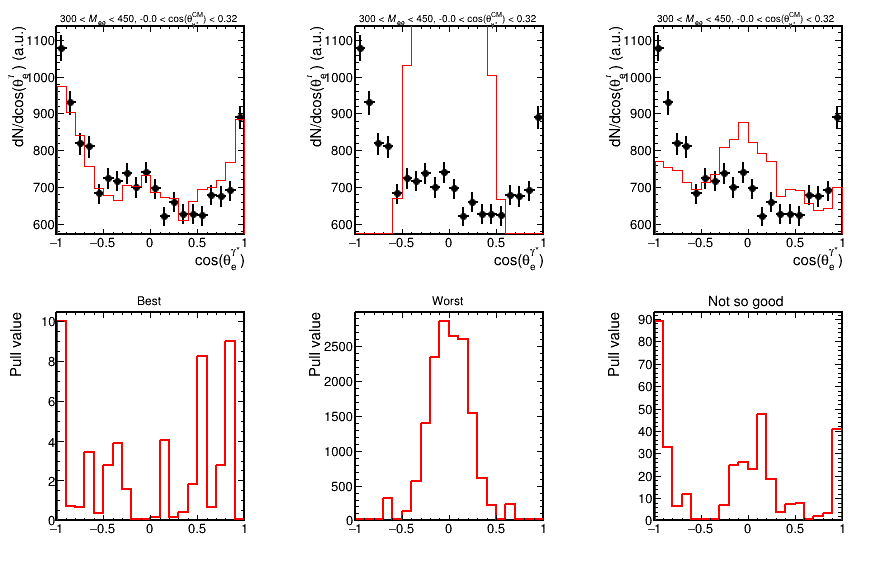

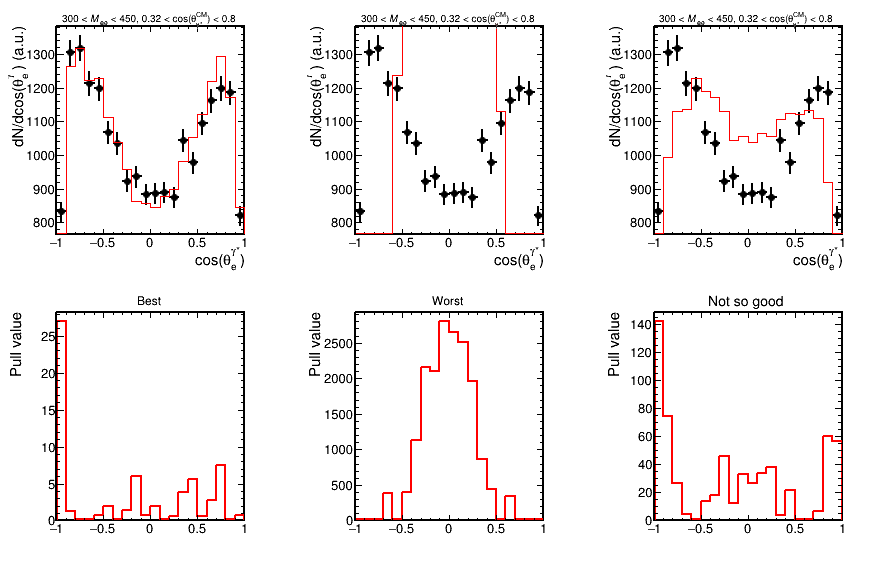

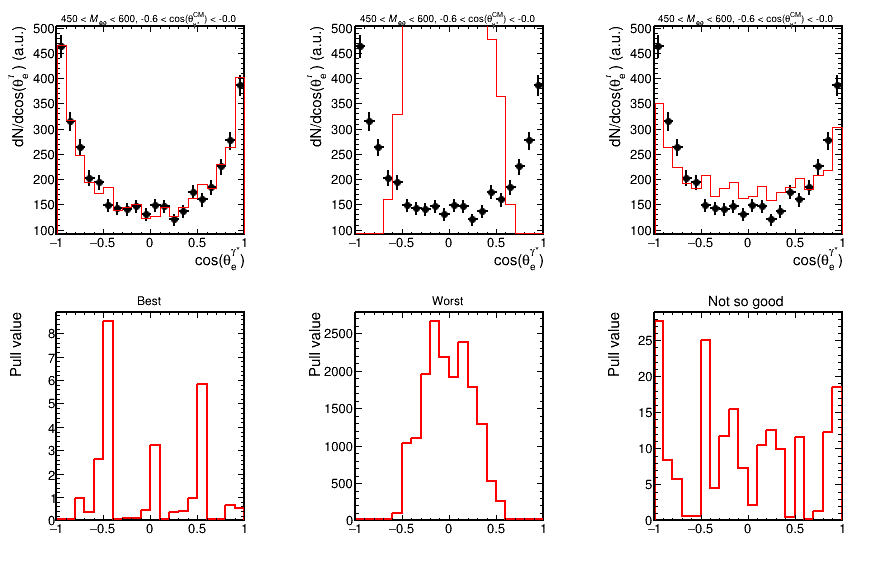

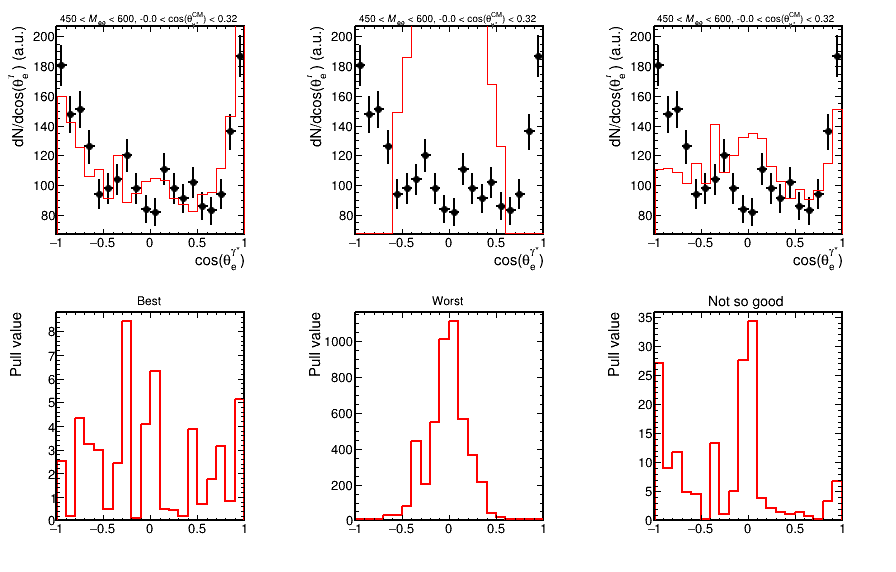

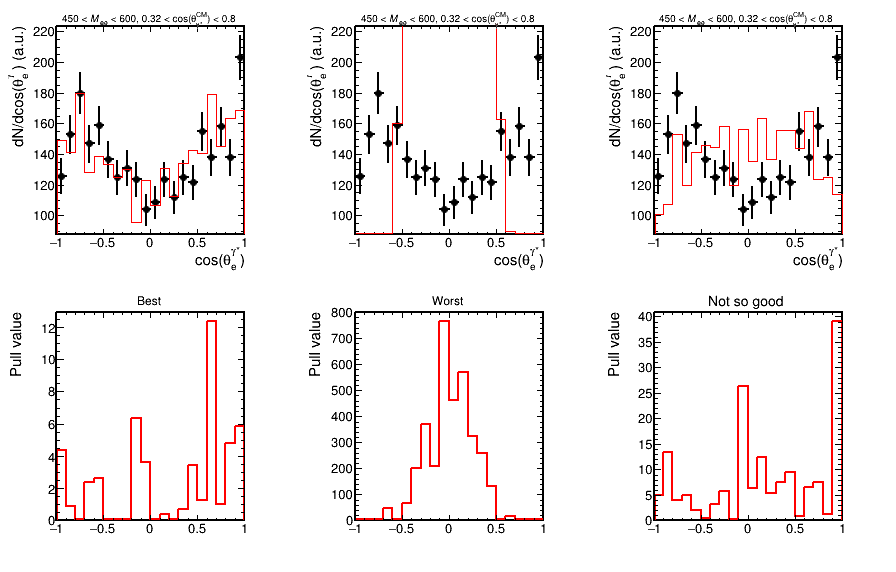

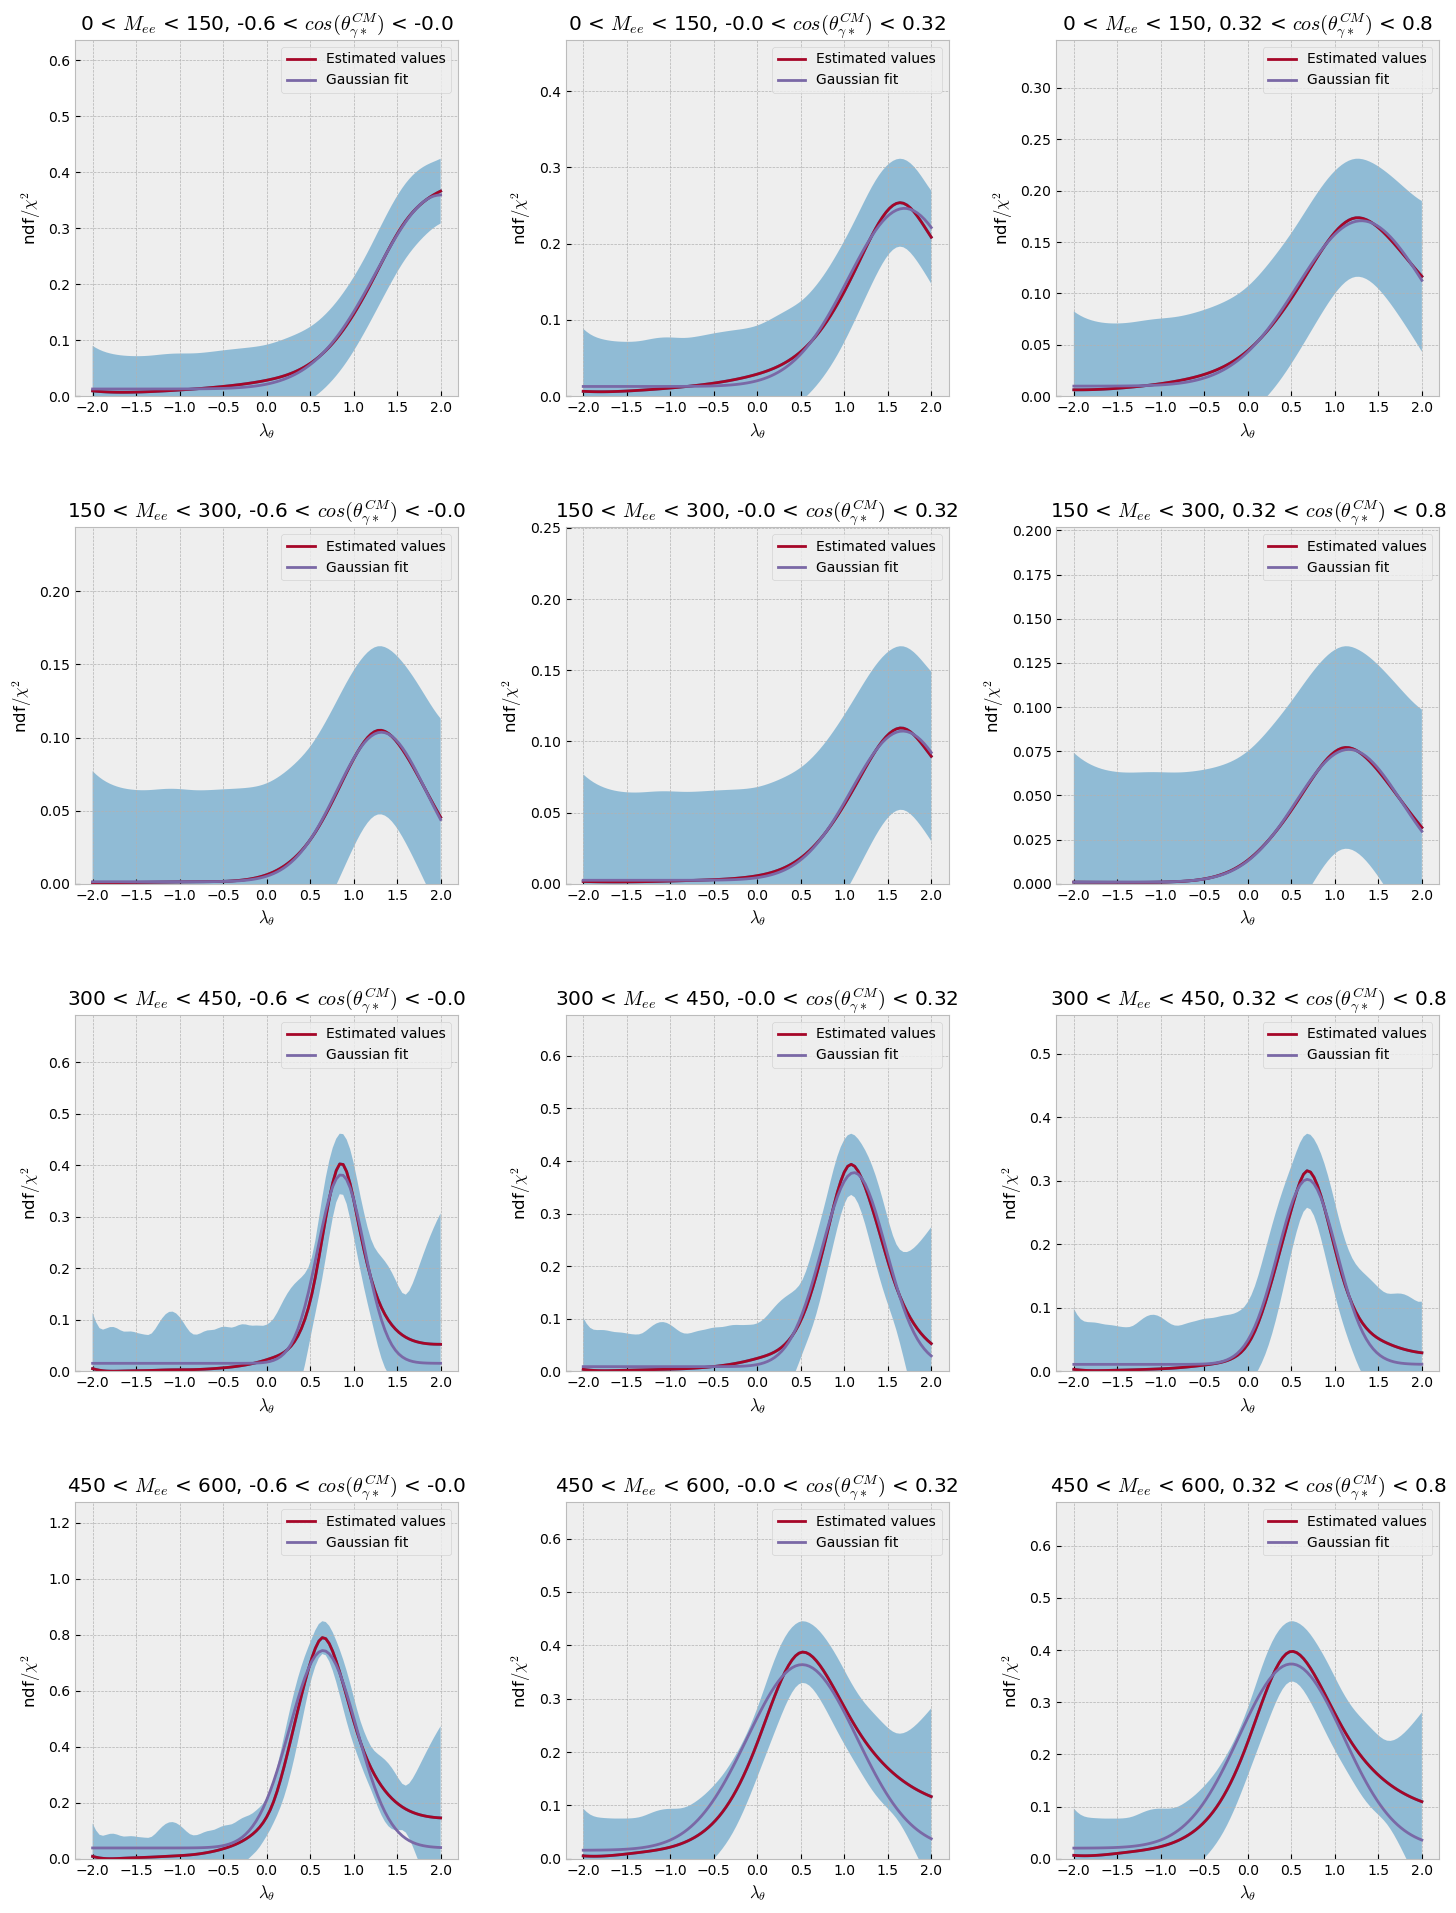

In [16]:

with open(f'{DIR_NAME}/results.txt', 'w') as fout:
    canvases = []
    hdiffs = []
    hmodels = []
    
    fig, ax = plt.subplots(nrows=4, ncols=3)
    fig.tight_layout()
    fig.set_figheight(20)
    fig.set_figwidth(15)
   # fig, ax = plt.subplots(nrows=1, ncols=1)
    
    for HIST_INDEX in range_used:

        c_sorted = c_sorted_all[HIST_INDEX - range_used.start]
        train_x_sorted = train_x_sorted_all[HIST_INDEX - range_used.start]
        predictive_mean = predictive_mean_all[HIST_INDEX - range_used.start]
        predictive_lower = predictive_lower_all[HIST_INDEX - range_used.start]
        predictive_upper = predictive_upper_all[HIST_INDEX - range_used.start]
        predictive_mean_2 = predictive_mean - predictive_mean.min()

       # ax = plt.axes()
       # fig, ax = plt.subplots(nrows=1, ncols=1)
        lambda_theta = train_x_sorted[-1]
        bestHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(bestHistsMC[0][HIST_INDEX])
        
        can1 = TCanvas(f"can_cmp_{HIST_INDEX}","can",900,600)
        can1.Divide(3,2)
        can1.Draw()        
        canvases.append(can1)
        
        hdiff1 = plotComparison(can1, 1, 4, bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Best")
        hdiffs.append(hdiff1)
        
        lambda_theta = train_x_sorted[0]
        worstHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(worstHistsMC[0][HIST_INDEX])
        hdiff2 = plotComparison(can1, 2, 5, worstHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Worst")
        hdiffs.append(hdiff2)

        shift = 0.75
        if train_x_sorted[-1] > shift - 1:
            diffToBest = torch.tensor([-shift])
        else:
            diffToBest = torch.tensor([+shift])
        lambda_theta = train_x_sorted[-1] + diffToBest
        notSoGoodHistsMC = getHistMakerMC(HIST_INDEX).makeHists(lambda_theta)
        hmodels.append(notSoGoodHistsMC[0][HIST_INDEX])
        hdiff22 = plotComparison(can1, 3, 6, notSoGoodHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX], HIST_INDEX, "Not so good")
        hdiffs.append(hdiff22)

        can1.SaveAs(f"{DIR_NAME}/comparison_{HIST_INDEX}.gif")

        mean, width = covariance_fit_scipy(predictive_mean,predictive_lower,predictive_upper,train_x_sorted[-1],HIST_INDEX,ax[HIST_INDEX // 3][HIST_INDEX % 3])

    
        n, meanX2, varX2, sigma2 = xAxisProperties(bestHistsMC[0][HIST_INDEX], histsData_np[0][HIST_INDEX])
        errB0 = math.sqrt(sigma2 * (1/n + meanX2 * meanX2 / varX2))
        errB1 = math.sqrt(sigma2 / varX2)
        ratioError = ratioErr(c_sorted[-1][1].item(), 1, errB1, errB0)

        try:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), " +- ", ratioError)
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), " +- ", ratioError, file=fout)
        except:
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item())
            print(str(HIST_INDEX) + ". Final result: lambda_theta = ", c_sorted[-1][1].item(), file=fout)


#2 [[<cppyy.gbl.TH1F object at 0x458975610>, <cppyy.gbl.TH1F object at 0x458975a00>, <cppyy.gbl.TH1F object at 0x458975df0>, <cppyy.gbl.TH1F object at 0x4589761e0>, <cppyy.gbl.TH1F object at 0x458974580>, <cppyy.gbl.TH1F object at 0x458974970>, <cppyy.gbl.TH1F object at 0x4589765f0>, <cppyy.gbl.TH1F object at 0x4589769e0>, <cppyy.gbl.TH1F object at 0x458976dd0>, <cppyy.gbl.TH1F object at 0x4589771c0>, <cppyy.gbl.TH1F object at 0x4589775b0>, <cppyy.gbl.TH1F object at 0x4589779a0>], [<cppyy.gbl.TH1F object at 0x28e830910>, <cppyy.gbl.TH1F object at 0x28e831430>], [<cppyy.gbl.TH1F object at 0x28e830ea0>, <cppyy.gbl.TH1F object at 0x28e831ac0>]]
#2 [[<cppyy.gbl.TH1F object at 0x45885f920>, <cppyy.gbl.TH1F object at 0x45886ba50>, <cppyy.gbl.TH1F object at 0x45886be40>, <cppyy.gbl.TH1F object at 0x45886c230>, <cppyy.gbl.TH1F object at 0x45886c620>, <cppyy.gbl.TH1F object at 0x45886ca10>, <cppyy.gbl.TH1F object at 0x45886ce00>, <cppyy.gbl.TH1F object at 0x45886d1f0>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/fit_classic.gif has been created
Info in <TCanvas::Print>: pdf file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/fit_classic.pdf has been created


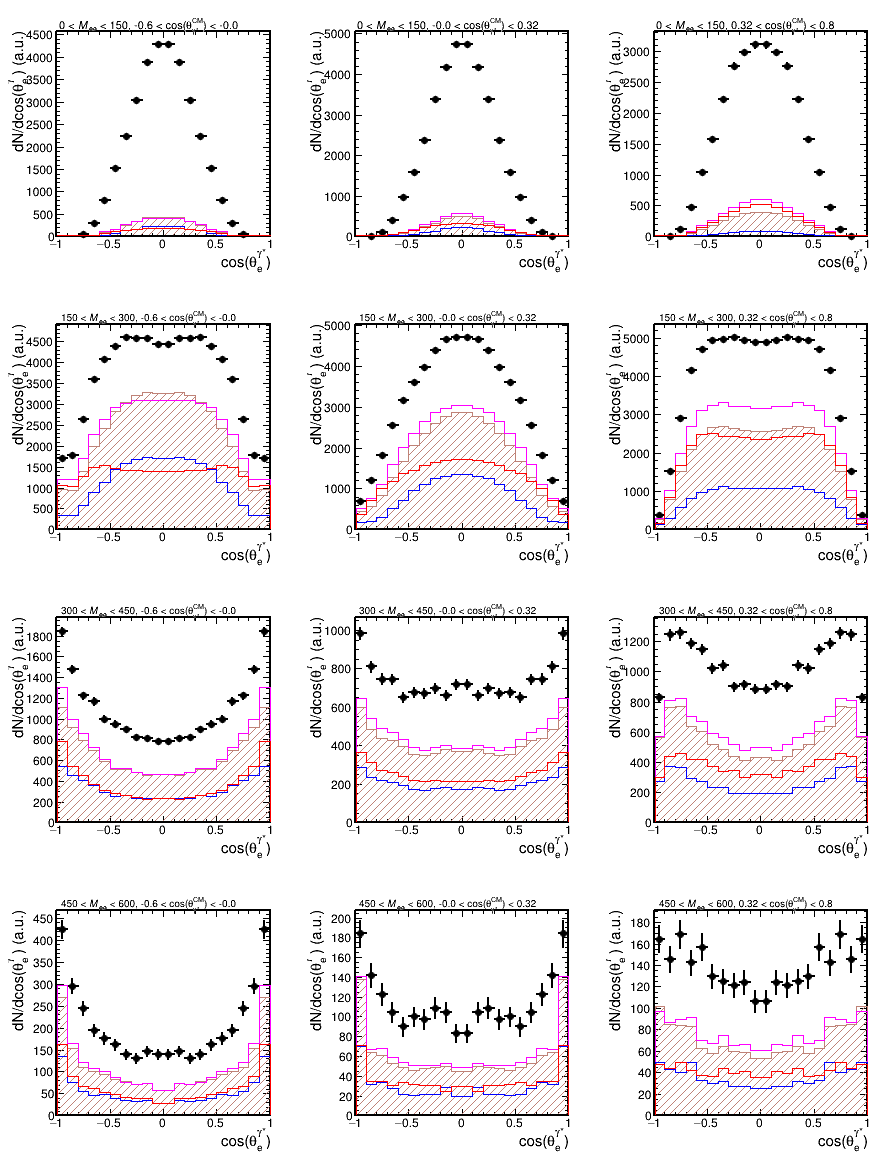

In [17]:
histsDataCorrs = []
hmodelLowM_null = histMakerMC_rho.makeHists((0.0))
hmodelLowM_null_mix = histMakerMC_mix.makeHists((0.0))
hmodelLowM_null_pi0 = histMakerMC_pi0.makeHists((0.0))
pol2s = []
paveTexts = []
histsAvg = []
kfactors = []

cc4 = TCanvas("cc4","cc4",900,1200)
cc4.Divide(3,4)
cc4.Draw()

cck = TCanvas("cck","cck",900,1200)
cck.Divide(3,4)

csig = TCanvas("csig","csig",900,1200)
csig.Divide(3,4)

for i, hist in enumerate(histsData_np[0]):
    
    if not isinstance(hist, list):

        hist_pp = histsData_pp[0][i]
        hist_nn = histsData_nn[0][i]
        
        symmetrize(hist)
        symmetrize(hist_pp)
        symmetrize(hist_nn)
        
        histAvg = geomAvg1d(hist_pp, hist_nn, 0.2)
        histsAvg.append(histAvg)

        
        histCorr = hist.Clone(hist.GetName() + "_corr")
        histsDataCorrs.append(histCorr)
        histCorr.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        pad = cc4.cd(i+1)
        setPad(pad)       
       
        hist_np_mix = histsData_np_mix[0][i]
        hist_pp_mix = histsData_pp_mix[0][i]
        hist_nn_mix = histsData_nn_mix[0][i]

        symmetrize(hist_np_mix)
        symmetrize(hist_pp_mix)
        symmetrize(hist_nn_mix)

        histAvg_mix = geomAvg1d(hist_pp_mix, hist_nn_mix, 0.2)
        hist_np_mix.Divide(histAvg_mix)
        hist_np_mix.Scale(2)
        kfactors.append(hist_np_mix)

        pad = cck.cd(i+1)
        setPad(pad)

        hist_np_mix.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
        setTH1(hist_np_mix, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist_pp_mix.SetLineColor(2)
        hist_nn_mix.SetLineColor(4)
        hist_pp_mix.SetMarkerColor(2)
        hist_nn_mix.SetMarkerColor(4)
        hist_np_mix.Draw()
        hist_pp_mix.Draw("SAME")
        hist_nn_mix.Draw("SAME")
        hist_np_mix.SetMinimum(0)
         
        pad = cc4.cd(i+1)
        setPad(pad)       
        
        histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
        histsAvg.append(histAvg_withK)
        histAvg_withK.Multiply(hist_np_mix)
        
        histAvg_withK.SetFillStyle(3004)
        histAvg_withK.SetFillColor(45)
        histAvg_withK.SetLineColor(45)
        histAvg.SetLineColor(6)
        hist_pp.SetLineColor(4)
        hist_nn.SetLineColor(2)
                
        setTH1(hist, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        hist.SetMinimum(0)
        hist.Draw()
        histAvg_withK.Draw("SAMEHIST")
        histAvg.Draw("SAMEHIST")
        hist_pp.Draw("SAMEHIST")
        hist_nn.Draw("SAMEHIST")
        
        pad = csig.cd(i+1)
        setPad(pad)     

        hist_model = hmodelLowM_null_mix[0][i]
        if not event_mixing:
            if i < 3:
                hist_model = hmodelLowM_null_pi0[0][i]
            else:
                hist_model = hmodelLowM_null[0][i]
        symmetrize(hist_model)

        histCorr.Add(histAvg_withK,-1)
        histCorr.Divide(hist_model)
            
       # symmetrize(histCorr)

        fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1,1)
        fit.SetParameters(1, 1)
        
        histCorr.Fit(fit,"Q")
        pol2s.append(fit)
    
        setTH1(histCorr, histCorr.GetXaxis().GetTitle(), f"dN/d{histCorr.GetXaxis().GetTitle()} (a.u.)", 
               505, 20, 0.8, 1)
        histCorr.Draw()
        if i < 3:
            histCorr.GetYaxis().SetRangeUser(0,2.5)
        else:
            histCorr.GetYaxis().SetRangeUser(0,1.25)    
        histCorr.SetMinimum(0)
        
        caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
        paveText = setOPT_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
        paveTexts.append(paveText)

    else:
        print(hist)

cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
    


Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/kfactor.gif has been created
Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/signal.gif has been created


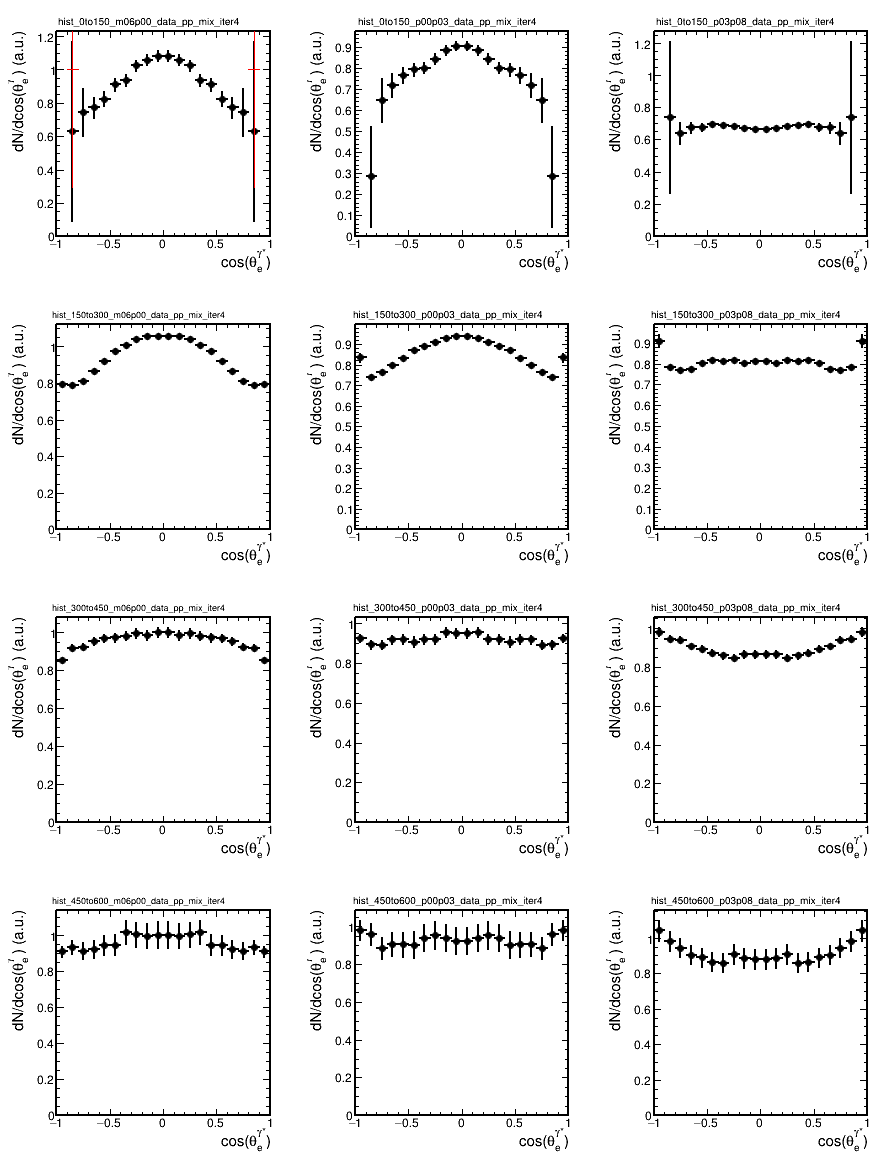

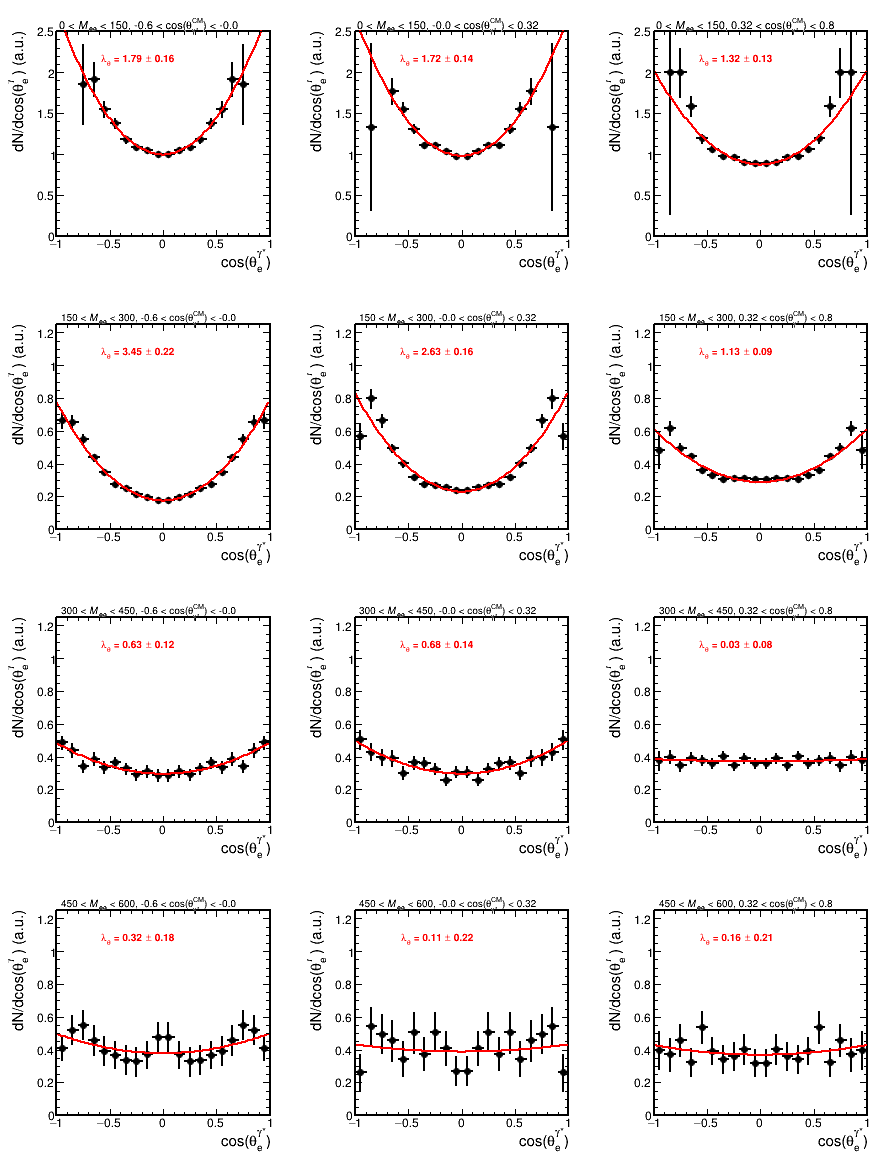

In [18]:
cck.Draw()
cck.SaveAs(f"{DIR_NAME}/kfactor.gif")

csig.Draw()
csig.SaveAs(f"{DIR_NAME}/signal.gif")

#2 [[<cppyy.gbl.TH1F object at 0x45451cdf0>, <cppyy.gbl.TH1F object at 0x45451d1e0>, <cppyy.gbl.TH1F object at 0x454521da0>, <cppyy.gbl.TH1F object at 0x454546190>, <cppyy.gbl.TH1F object at 0x454546580>, <cppyy.gbl.TH1F object at 0x454546970>, <cppyy.gbl.TH1F object at 0x454546d60>, <cppyy.gbl.TH1F object at 0x454547150>, <cppyy.gbl.TH1F object at 0x454547540>, <cppyy.gbl.TH1F object at 0x454547930>, <cppyy.gbl.TH1F object at 0x454547d20>, <cppyy.gbl.TH1F object at 0x454548110>], [<cppyy.gbl.TH1F object at 0x28e830910>, <cppyy.gbl.TH1F object at 0x28e831430>], [<cppyy.gbl.TH1F object at 0x28e830ea0>, <cppyy.gbl.TH1F object at 0x28e831ac0>]]
#2 [[<cppyy.gbl.TH1F object at 0x454548500>, <cppyy.gbl.TH1F object at 0x4545488f0>, <cppyy.gbl.TH1F object at 0x454548ce0>, <cppyy.gbl.TH1F object at 0x4545490d0>, <cppyy.gbl.TH1F object at 0x4545495d0>, <cppyy.gbl.TH1F object at 0x4545499c0>, <cppyy.gbl.TH1F object at 0x454549db0>, <cppyy.gbl.TH1F object at 0x45454a1a0>, <cppyy.gbl.TH1F object at

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/cmp_mass_z.gif has been created


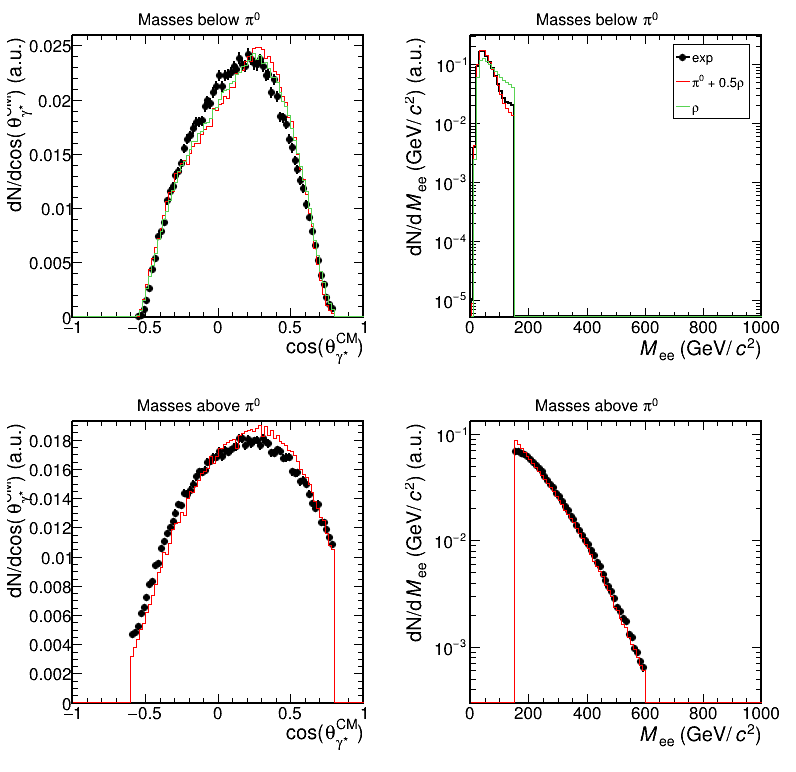

In [19]:
hmodelLowM_rho = histMakerMC_mix.makeHists((1.0)) if event_mixing else histMakerMC_rho.makeHists((1.0))
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.makeHists((1.0))

fraction = 0.5

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = getHistMakerMC(3).makeHists(1.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

pad = cc.cd(1)
setPad(pad)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")

setTH1(histsData_np[2][0], histsData_np[2][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
setPad(pad)
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")

setTH1(histsData_np[1][0], histsData_np[1][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], f"#pi^{{0}} + {fraction}#rho", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

pad = cc.cd(3)
setPad(pad)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")

setTH1(histsData_np[2][1], histsData_np[2][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
#hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
setPad(pad)
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")

setTH1(histsData_np[1][1], histsData_np[1][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
#hmodelLowM_rho[1][1].Draw("SAMEHIST")

cc.SaveAs(f"{DIR_NAME}/cmp_mass_z.gif")

Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/cmp_mass_z.gif has been created


Info in <TCanvas::Print>: gif file results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr/cmp_mass_z.gif has been created
